# Reinforcement Learning - Platfrom env


The objectif of this notebook is to build and train a Agent on the Plateform environment.

### The Plateform env is caracterized by:

**Game Objectif:**  
The objectif of the player is to reach the far right side of the bord without touching an enemy of falling into a gap along the way.

**Description of the state and action spaces:**

The state space and the action spaces are continuous. 

There are 3 types of actions: hop(), leap(), run(). These actions are parametrized: when calling an action we need to input the "power" x with which the action will be performed. The action space is $\big\{(\text'run', 0\leq x \leq 30), (\text'hop', 0 \leq x \leq 720), (\text'leap', 0 \leq x \leq 430)\big\}$

The state space is defined by 9 parameters:
- The first 4 parameters of the state vector are: 
    - the player's position along the x-axis (>0), 
    - the player's speed along the x-axis,
    - the incoming-enemy's position along the x-axis,
    - the incoming-enemy's speed along the x-axis (<0).


- The 5 last parameters of the state vector are:
    - the width of the current platform,
    - the width of the next platform (=0 if the player is already on the last platform),
    - the width of the incoming gap,
    - the position (the start) of the current platform along the x axis,
    - the delta of height between the current and the next platform.
    
**Reward function:**  
"The reward for a step is the change in x value for that step, divided by the total length of all the platforms and gaps."

## Implementation

After reading papers on parametrized-action reinforcement learning, I chose to implement the startegy of "Parametrized Deep Q-Networks Learning: Reinforcement
Learning with Discrete-Continuous Hybrid Action Space" Xiong and al. [https://arxiv.org/pdf/1810.06394.pdf]

The article's team proposes a Parametrized DQN. 

Because I did not reach a converging implementation of the P-QDN, I propose, in a second section, an implementation of a simple DQN over a discreatized version of the Platform environment.

# Imports

In [1]:
import gym
import gym_platform
from gym_platform import *
import pygame

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import random
import os
import copy

import torch as T  
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

/Users/gladys.roch/.local/share/virtualenvs/Projects-rn3bn9bu/lib/python3.8/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/Users/gladys.roch/.local/share/virtualenvs/Projects-rn3bn9bu/lib/python3.8/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


In [3]:
env = gym.make('Platform-v0')
print(env.action_space, "\n")
print(env.observation_space, "\n")
env.close()

Tuple(Discrete(3), Tuple(Box(0.0, 30.0, (1,), float32), Box(0.0, 720.0, (1,), float32), Box(0.0, 430.0, (1,), float32))) 

Tuple(Box(0.0, 1.0, (9,), float32), Discrete(200)) 



/Users/gladys.roch/.local/share/virtualenvs/Projects-rn3bn9bu/lib/python3.8/site-packages/gym/spaces/box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


---
**Game Objectif:**  
The objectif of the player is to reach the far right side of the bord without touching an enemy of falling into a gap along the way.

**Description of the state and action spaces:**

The state space and the action spaces are continuous. 

There are 3 types of actions: hop(), leap(), run(). These actions are parametrized: when calling an action we need to input the "power" x with which the action will be performed. The action space is $\big\{(\text'run', 0\leq x \leq 30), (\text'hop', 0 \leq x \leq 720), (\text'leap', 0 \leq x \leq 430)\big\}$

The state space is defined by 9 parameters:
- The first 4 parameters of the state vector are: 
    - the player's position along the x-axis (>0), 
    - the player's speed along the x-axis,
    - the incoming-enemy's position along the x-axis,
    - the incoming-enemy's speed along the x-axis (<0).


- The 5 last parameters of the state vector are:
    - the width of the current platform,
    - the width of the next platform (=0 if the player is already on the last platform),
    - the width of the incoming gap,
    - the position (the start) of the current platform along the x axis,
    - the delta of height between the current and the next platform.
    
**Reward function:**  
"The reward for a step is the change in x value for that step, divided by the total length of all the platforms and gaps."

In [4]:
import gym

env = gym.make('Platform-v0')
observation = env.reset()

for _ in range(20):
    env.render()
    action = env.action_space.sample() # your agent here (this takes random actions)
    observation, reward, done, info = env.step(action)
    if done:
        observation = env.reset()
env.close()
pygame.quit()

2022-04-24 23:01:37.183 Python[15543:6850059] ApplePersistenceIgnoreState: Existing state will not be touched. New state will be written to (null)


# P-DQN

In this section I implement the P-DQN agent following the pseudo-code from the article 

*Parametrized Deep Q-Networks Learning: Reinforcement Learning with Discrete-Continuous Hybrid Action Space, [Xiong and al.].*

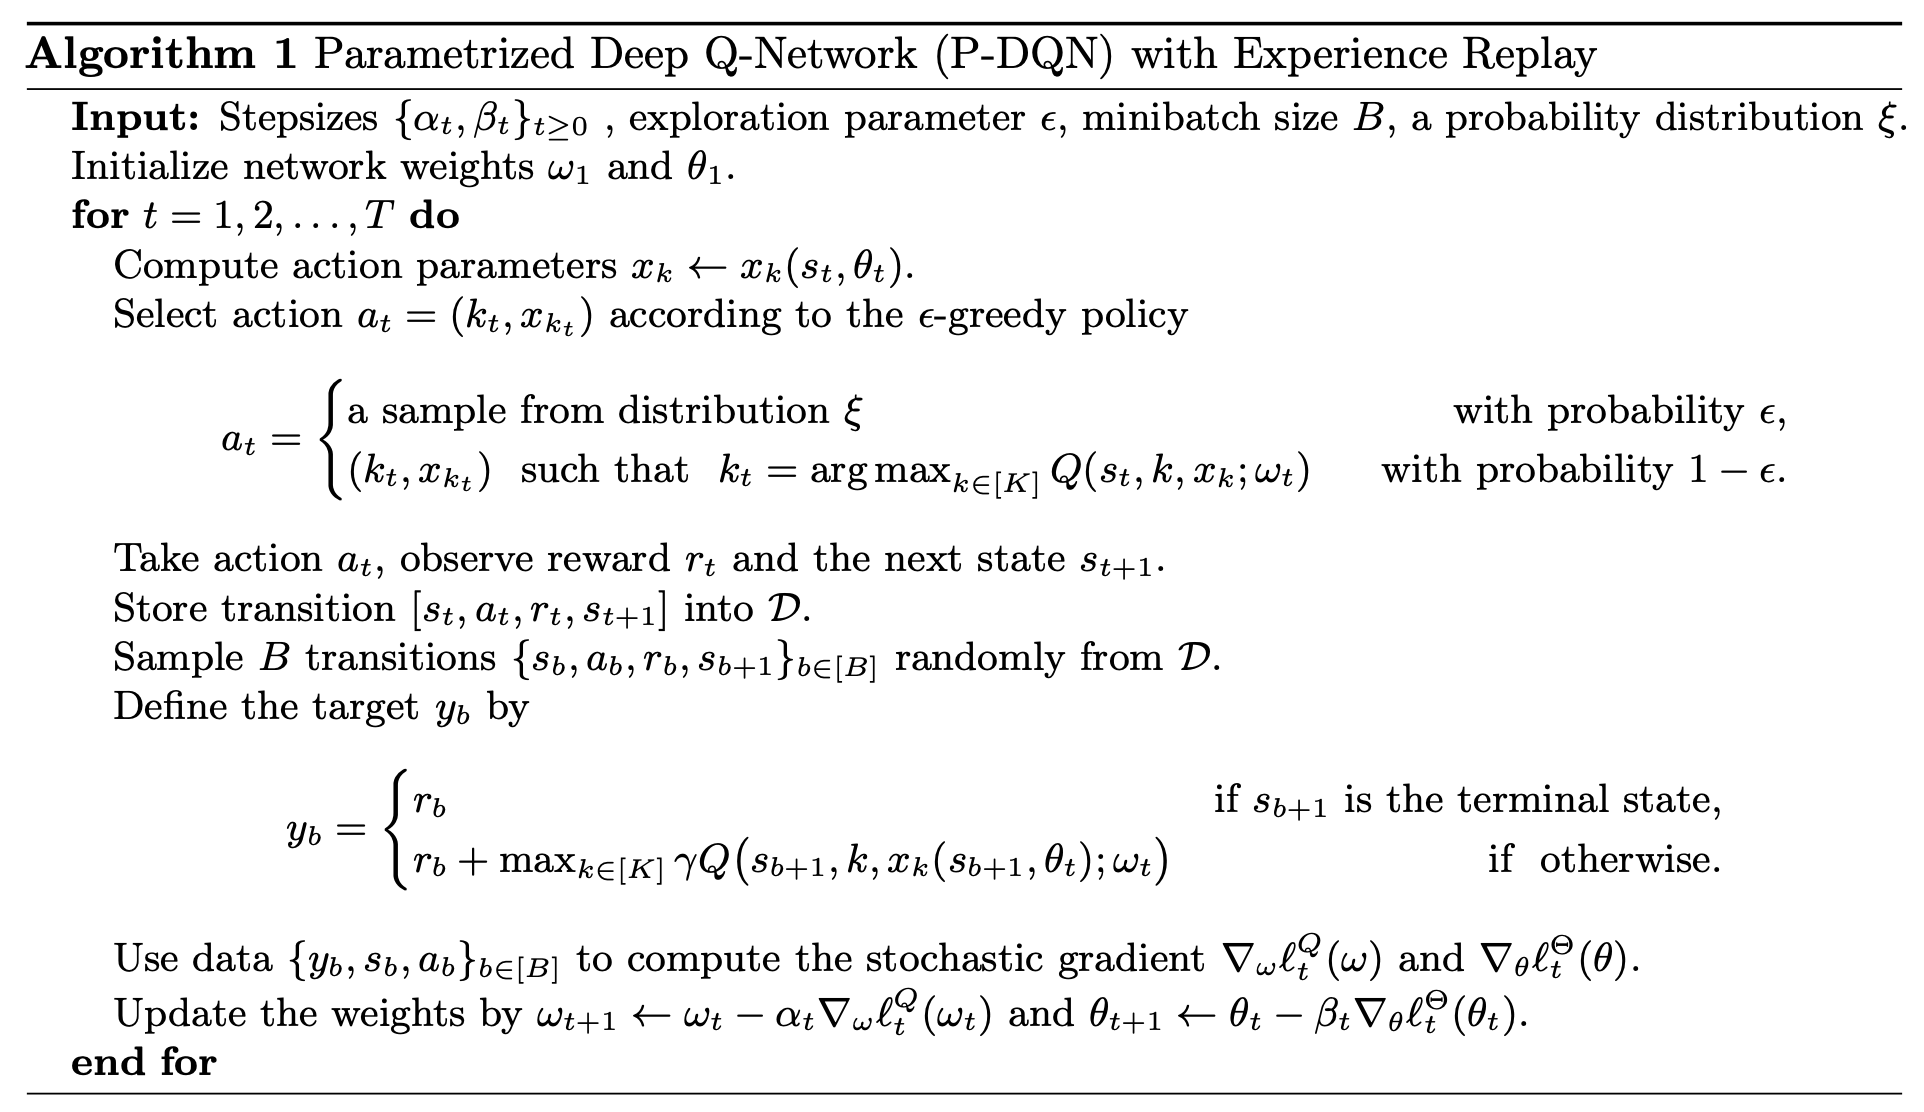

With $$l_{t}^{Q}(w) = \frac{1}{2}[Q(s_t, k_t, x_{k_t}; w) - y_t]^2$$
and $$l_t^\Theta(\theta) = - \sum_{k=1}^{K}{Q(s_t, k, x_k(s_t;\theta);w_t)}$$

In [495]:
class ReplayBuffer2():
    """
    This replay buffer allows to store and sample experiements on the environnement 
    composed of (state, new state, action, action parameters, reward, dones)
    :param mem_size: the memory size, once the memory size is reached the new samples 
                     overwrite the first ones following a deque scheme
    """

    def __init__(self, max_size, input_shape=9, n_actions=3):
        self.mem_size = max_size
        self.mem_cpt = 0
        self.state_memory = np.zeros((self.mem_size, input_shape), dtype=float)
        self.new_state_memory = np.zeros((self.mem_size, input_shape), dtype=float)
        self.action_memory = np.zeros((self.mem_size, 1), dtype=int)
        self.action_param_memory = np.zeros((self.mem_size, n_actions), dtype=float)
        self.reward_memory = np.zeros(self.mem_size, dtype=float)
        self.terminal_memory = np.zeros(self.mem_size, dtype=int)
    
    def store_transition(self, state, action_id, action_params, reward, state_, done):
        """
        saves a given experiment
        """
        index = self.mem_cpt % self.mem_size  # when the memory is full we start overwriting the first stored transactions
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.terminal_memory[index] = done
        self.reward_memory[index] = reward
        self.action_memory[index] = action_id
        self.action_param_memory[index] = np.hstack(action_params)
        self.mem_cpt += 1

    def sample_buffer(self, batch_size):
        """
        return batch_size random experiments from the memory. The samples are not duplicated.
        """
        max_mem = min(self.mem_cpt, self.mem_size)
        batch = np.random.choice(max_mem, batch_size)
        states = self.state_memory[batch]        
        states_ = self.new_state_memory[batch] 
        actions_ids = self.action_memory[batch]
        actions_params = self.action_param_memory[batch]
        rewards = self.reward_memory[batch]
        dones = self.terminal_memory[batch]    

        return states, actions_ids, actions_params, rewards, states_, dones
    

In [497]:
class PolicyNetwork(nn.Module):
    """
    This class implements the network that approximates the policy of the action 
    parameters. It refers to x in the pseudo-code. This policy network returns a 
    vector of dimention the total number of parameters of all the actions.
    The initialisation of the weights follows a standard rule based on the layers' 
    input dimention.
    """
    
    def __init__(self, name, beta, state_dim, action_dim):
        super(PolicyNetwork, self).__init__()
        self.input_dims = state_dim
        self.output_dims = action_dim
        self.fc1_dims = 64        #hidden layers
        self.fc2_dims = 64        #hidden layers
        self.checkpoint_file = os.path.join("checkpoint_folder", name)
        
        self.fc1 = nn.Linear(self.input_dims, self.fc1_dims) #state + action
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.param = nn.Linear(self.fc2_dims, self.output_dims)
        
        # initialize weights with input dimention of each layer
        '''y = [1/math.sqrt(n) for n in [self.input_dims, self.fc1_dims, self.fc2_dims]]
        for i, layer in enumerate([self.fc1, self.fc2, self.param]):
            T.nn.init.uniform_(layer.weight.data, -y[i], y[i])
            T.nn.init.zeros_(layer.bias.data)'''
        
        self.optimizer = optim.Adam(self.parameters(), lr=beta)
        self.device = T.device('cuda' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        act_param = F.leaky_relu(self.fc1(state))
        act_param = F.leaky_relu(self.fc2(act_param))
        act_param = F.sigmoid(self.param(act_param))  # force the output between 0 and 1
        return act_param
    
    def save_checkpoint(self):
        print(".. saving checkpoint")
        T.save(self.state_dict(), self.checkpoint_file)
        
    def load_checkpoint(self):
        print(".. loading checkpoint")
        self.load_state_dict(T.load(self.checkpoint_file))

        
class QValueNetwork(nn.Module):
    """
    This class implements the network that approximates the action-value function (Q).
    """
    
    def __init__(self, name, alpha, state_dim, param_dim, action_dim):
        super(QValueNetwork, self).__init__()
        self.input_dims = state_dim + param_dim
        self.output_dims = action_dim
        self.fc1_dims = 64        #hidden layers
        self.fc2_dims = 64        #hidden layers
        self.checkpoint_file = os.path.join("checkpoint_folder", name)
        
        self.fc1 = nn.Linear(self.input_dims, self.fc1_dims) #state + action
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.q = nn.Linear(self.fc2_dims, self.output_dims)
        
        # initialize weights with input dimention of each layer
        y = [1/math.sqrt(n) for n in [self.input_dims, self.fc1_dims, self.fc2_dims]]
        for i, layer in enumerate([self.fc1, self.fc2, self.q]):
            T.nn.init.uniform_(layer.weight.data, -y[i], y[i])
            T.nn.init.zeros_(layer.bias.data)
        
        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device = T.device('cuda' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state, act_param):
        x = T.cat([state, act_param], dim=1)
        qvalues = F.leaky_relu(self.fc1(x))
        qvalues = F.leaky_relu(self.fc2(qvalues))
        qvalues = self.q(qvalues)
        return qvalues
    
    def save_checkpoint(self):
        print(".. saving checkpoint")
        T.save(self.state_dict(), self.checkpoint_file)
        
    def load_checkpoint(self):
        print(".. loading checkpoint")
        self.load_state_dict(T.load(self.checkpoint_file))

In [500]:
class AgentPDQN(object):
    """
    This class implements the P-QDN agent and its learning framework based on 
    the Bellman's equation adapted to parametrized actions.
    """
    def __init__(self, alpha, beta, gamma=0.99,
                 n_actions=3, state_dim=9, param_dim=3, max_size=1000,  batch_size=64):
        T.manual_seed(42)
        self.gamma = gamma
        self.n_actions = n_actions
        self.memory = ReplayBuffer2(max_size)
        self.batch_size = batch_size
        self.policy_net = PolicyNetwork(beta=beta, state_dim=state_dim, action_dim=n_actions, name="policy_net")
        self.qvalue_net = QValueNetwork(alpha=alpha, state_dim=state_dim, param_dim=param_dim, action_dim=n_actions, name="qvalue_net")
        self.target_policy_net = copy.deepcopy(self.policy_net).eval()
        self.target_qvalue_net = copy.deepcopy(self.qvalue_net).eval()
        self.Q_loss = []
        self.P_loss = []

    def remember(self, state, action_id, action_params, reward, new_state, done):
        self.memory.store_transition(state, action_id, action_params, reward, new_state, done)

    def learn(self):
        # --------------------------------------
        # Wait for memory to be large enough
        # --------------------------------------
        if self.memory.mem_cpt < self.batch_size:
            return 
        
        self.qvalue_net.train()
        self.policy_net.train()
        # ---------------------------------
        # Sample from replay buffer
        # ---------------------------------
        states, action_ids, action_params, rewards, new_states, dones = self.memory.sample_buffer(self.batch_size)
        
        states = T.tensor(states, dtype=T.float).to(self.qvalue_net.device)
        action_ids = T.tensor(action_ids, dtype=T.int).to(self.qvalue_net.device)
        action_params = T.tensor(action_params, dtype=T.float).to(self.qvalue_net.device)
        rewards = T.tensor(rewards, dtype=T.float).to(self.qvalue_net.device)
        new_states = T.tensor(new_states, dtype=T.float).to(self.qvalue_net.device)
        dones = T.tensor(dones).to(self.qvalue_net.device)
        
        # ---------------------------------
        # Apply Bellman's Equation
        # ---------------------------------
        with T.no_grad():
            # ----- Bellman's Equation:
            # Define x_k(s_b+1, theta_t)
            pred_new_act_params = self.policy_net.forward(new_states)
            # Define Q(s_b+1, k, x_k(s_b+1, theta_t), w_t)
            qvalues_new_state = self.qvalue_net.forward(new_states, pred_new_act_params) 

            # ----- A loop to make sure we have the correct dimension for the target tensor (y_b)
            targets = []
            for b in range(self.batch_size):
                targets.append(rewards[b] + T.max(self.gamma*qvalues_new_state[b])*(1-dones[b]))
            targets = T.tensor(targets).to(self.qvalue_net.device)
            targets = targets.view(self.batch_size, 1)  # needed to have same shape as qvalues

        # ---------------------------------
        # Compute Loss for QValue-network 
        # ---------------------------------
        # Define Q(s_t, k_t, x_t, w) - current qvalues
        qvalues = self.qvalue_net.forward(states, action_params) # yields (batch, 3) tensor
        qvalues = qvalues.gather(1, action_ids.type(T.int64))  # retains the qvalue of the action taken 
        Q_loss = F.mse_loss(targets, qvalues)
        
        self.qvalue_net.optimizer.zero_grad()
        Q_loss.backward()
        self.qvalue_net.optimizer.step()

        # ---------------------------------
        # Compute Loss for Policy-network
        # ---------------------------------
        with T.no_grad():
            x_params = self.policy_net.forward(states)  # x_k(s_t, theta)
        x_params.requires_grad = True
        qvalues_from_net = self.qvalue_net.forward(states, x_params)  # Q(s_t, k, x_k(s_t, theta), w_t)
        
        bounds = T.tensor([30, 720, 430])
        #lower_param_bounds =  - (T.minimum(T.tensor([0, 0, 0]), x_params)/bounds).sum(dim=1)
        #higher_param_bounds = (T.maximum(T.tensor([0, 0, 0]), x_params - bounds)/bounds).sum(dim=1)
        #loss_outside_bounds = lower_param_bounds + higher_param_bounds
        P_loss = - qvalues_from_net.sum(dim=1) #+ loss_outside_bounds/2 # sum of qvalues of all actions
        P_loss = T.mean(P_loss)
        
        self.policy_net.optimizer.zero_grad()
        P_loss.backward()
        self.policy_net.optimizer.step()
        
        # self.update_network_parameters()
        
        agent.P_loss.append(P_loss.detach().cpu().numpy())
        agent.Q_loss.append(Q_loss.detach().cpu().numpy())
    
    def update_network_parameters(self, tau=0.001):
        policy_params = self.policy_net.named_parameters()
        qvalue_params = self.qvalue_net.named_parameters()
        target_policy_params = self.target_policy_net.named_parameters()
        target_qvalue_params = self.target_qvalue_net.named_parameters()

        policy_state_dict = dict(policy_params)
        qvalue_state_dict = dict(qvalue_params)
        target_policy_dict = dict(target_policy_params)
        target_qvalue_dict = dict(target_qvalue_params)

        for name in policy_state_dict:
            policy_state_dict[name] = tau*policy_state_dict[name].clone() + (1-tau)*target_policy_dict[name].clone()
        self.target_policy_net.load_state_dict(policy_state_dict)

        for name in qvalue_state_dict:
            qvalue_state_dict[name] = tau*qvalue_state_dict[name].clone() + (1-tau)*target_qvalue_dict[name].clone()
        self.target_qvalue_net.load_state_dict(qvalue_state_dict)
        
    def save_models(self):
        self.policy_net.save_checkpoint()
        self.qvalue_net.save_checkpoint()
        
    def load_models(self):
        self.policy_net.load_checkpoint()
        self.qvalue_net.load_checkpoint()
        
        

In [501]:
def choose_action2(agent, observation, eps_threshold):
    """
    Choose the action following the epsilon-greedy policy.
    
    Note: this function returns a twin tuple to allow for easy switch 
    with the other "choose_action" definition of the next cell.
    """
    with T.no_grad():
        # --------------------------
        # compute_action_params
        # --------------------------
        observation = T.tensor(observation, dtype=T.float).view(1, -1).to(agent.policy_net.device)
        act_params = agent.policy_net.forward(observation)
        act_params = act_params.view(1, -1).to(agent.qvalue_net.device)

        p = random.random()
        if p > eps_threshold:
            action = np.argmax(agent.qvalue_net(observation, act_params).cpu().detach().numpy())
            action = (action, tuple(act_params.reshape(agent.n_actions, 1).cpu().detach().numpy()))
        else:
            action = env.action_space.sample()
            
    return action, action

In [502]:
def choose_action(agent, observation, eps_threshold):
    """
    Choose the action following the epsilon-greedy policy. 
    
    This function supposes that the policy network of the agent yields 
    ouputs between 0 and 1 and then multiply by the tensor of the bounds 
    of the action parameters to return the action to be feed to the env.
    
    action_denormalized: action to feed to the env (multiplied by [30, 720, 430])
    action: action between 0 and 1
    """
    with T.no_grad():
        # --------------------------
        # compute_action_params
        # --------------------------
        observation = T.tensor(observation, dtype=T.float).view(1, -1).to(agent.policy_net.device)
        act_params = agent.policy_net.forward(observation)
        act_params = act_params.view(1, -1).to(agent.qvalue_net.device)

        p = random.random()
        if p > eps_threshold:
            action = np.argmax(agent.qvalue_net(observation, act_params).cpu().detach().numpy())
            act_params_denormalized = act_params * T.tensor([[30, 720, 430]])
            
            action = (action, tuple(act_params.reshape(agent.n_actions, 1).cpu().detach().numpy()))
            action_denormalized = (action[0], tuple(act_params_denormalized.reshape(agent.n_actions, 1).cpu().detach().numpy()))
        else:
            action_denormalized = env.action_space.sample()
            act_params_normalized = np.hstack(list(action_denormalized[1])) / np.array([30, 720, 430])
            action = (action_denormalized[0], act_params_normalized)
    
    return action_denormalized, action


In [503]:
def evaluate(agent):
    """
    Runs the agent following the learned policy (epsilon_threshold = 0) and returns the score achieved.
    """
    score = 0
    
    env = gym.make('Platform-v0')
    observation, _ = env.reset()
    done = False
    while not done:
        env.render()
        action, action_normalized = choose_action(agent, observation, 0)  # eps = 0 -> take best action
        observation, reward, done, info = env.step(action)
        observation, _ = observation
        score += reward
    env.close()
    pygame.quit()
    
    return score

In [504]:
def train(agent, n_episodes, env, eps_start, eps_end, eps_decay, verbose=True):
    scores = []
    scores_100_avg = []
    scores_eval = []
    for i in range(n_episodes):
        obs, _ = env.reset()
        done = False
        score = 0

        while not done:
            # ------------------------------------------------------------
            # Update the epsilon threshold for the epsilon-greedy policy
            # ------------------------------------------------------------
            eps_threshold = eps_end + (eps_start - eps_end) * math.exp(-1. * i / eps_decay) if i < eps_decay else eps_end
            # ------------------------
            # Choose and take action
            # ------------------------
            action, action_normalized = choose_action(agent, obs, eps_threshold)
            (new_state, _), reward, done, info = env.step(action)
            # ---------------------------
            # Store experiment in memory
            # ---------------------------
            agent.remember(obs, action_normalized[0], action_normalized[1], reward, new_state, int(done))
            # ---------------------------
            # Launch agent training step
            # ---------------------------
            agent.learn()  # temporal diff learning method -> learn at every step instead of at the end of the episode

            score += reward
            obs = new_state

        # ---------------------------
        # compute stats and verbose
        # ---------------------------
        scores.append(score)
        scores_100_avg.append(round(np.mean(scores[-100:]), 3))
        if i%1000 == 0:
            scores_eval.append(evaluate(agent))
            
        if verbose:
            if i%1000 == 0:
                print(f"Episode {i}, score = {round(score, 2)}, last 100 games average = {round(np.mean(scores[-100:]), 2)}")

            if i!=0 and i%10000 == 0:
                agent.save_models()
                print(f"Mean score over 100 games using current policy = {round(tot_reward, 3)}")

            if i!=0 and i%5000 == 0:
                plt.figure(figsize=(7, 3))
                plt.scatter(x=np.arange(0, i+1, 1, dtype=int), y=scores, marker='.')
                plt.scatter(x=np.arange(0, i+1, 1, dtype=int), y=scores_100_avg, marker='.')
                plt.scatter(x=np.arange(0, i+1, 1000, dtype=int), y=scores_eval, marker='o')
                plt.ylim([0, 1])
                plt.xlim([0, n_episodes])
                plt.show()

    return scores, scores_100_avg, scores_eval

In [ ]:
ALPHA = 0.01
BETA = ALPHA*10 # lr scheduler to try
GAMMA = 0.99
BATCH_SIZE = 64
MEM_SIZE = 10000
N_EPISODES = 100000
EPS_START = 0.9
EPS_END = 0.01
EPS_DECAY = N_EPISODES # after n actions exploration is limited to a probability of 0.01
N_ACTIONS = 3

# ------------------------------------
# Instanciate the env and the agent
# ------------------------------------
env = gym.make('Platform-v0')
agent = AgentPDQN(
    alpha=ALPHA, 
    beta=BETA, 
    batch_size=BATCH_SIZE, 
    max_size=MEM_SIZE, 
    gamma=GAMMA, 
    n_actions=N_ACTIONS,
    state_dim=9,
    param_dim=3
)

scores, scores_100_avg, scores_eval = train(agent, N_EPISODES, env, EPS_START, EPS_END, EPS_DECAY)

env.close()

In [ ]:
plt.figure(figsize=(20, 5))

plt.subplot(121)
plt.scatter(x=np.arange(0, N_EPISODES, 1, dtype=int), y=scores, marker='.')
plt.scatter(x=np.arange(0, N_EPISODES, 1, dtype=int), y=scores_100_avg, marker='.')
plt.scatter(x=np.arange(0, N_EPISODES, 1000, dtype=int), y=scores_eval, marker='.')
plt.ylim([0,1])
plt.xlim([0,N_EPISODES])
plt.xlabel("n° episode")
plt.ylabel("Score at termination of episode")
plt.title("Score of the agent during training")

plt.subplot(222)
plt.plot(agent.Q_loss)
plt.ylim([-1.5, 0])
plt.title("Q-Value network loss")
plt.subplot(224)
plt.plot(agent.P_loss)
plt.ylim([0, 1])
plt.title("Policy network loss")
plt.show()

In [359]:
agent.load_models()
tot_reward = 0
for _ in range(10):
    tot_reward += evaluate(agent)

.. loading checkpoint
.. loading checkpoint


# DQN - Discretized actions' space

In this section, I downgrade the environment from an parametrized action env to a discrete actions env. I choose to keep the following action:

- (run, 10), (run, 20), (run, 30)  
- (hop, 240), (hop, 480), (hop, 720)  
- (leap, 143), (leap, 286), (leap, 430)

I implement the classes need to build a DQN that learn the best policy based on the approximation of the action-value by a network.

In [554]:
class ReplayBufferDiscrete():
    """
    This replay buffer allows to store and sample experiements on the environnement 
    composed of (state, new state, action, reward, dones)
    :param mem_size: the memory size, once the memory size is reached the new samples 
                     overwrite the first ones following a deque scheme
    """

    def __init__(self, max_size, input_shape=9, n_actions=3):
        self.mem_size = max_size
        self.mem_cpt = 0
        self.state_memory = np.zeros((self.mem_size, input_shape), dtype=float)
        self.new_state_memory = np.zeros((self.mem_size, input_shape), dtype=float)
        self.action_memory = np.zeros((self.mem_size, 1), dtype=int)
        self.reward_memory = np.zeros(self.mem_size, dtype=float)
        self.terminal_memory = np.zeros(self.mem_size, dtype=int)
    
    def store_transition(self, state, action, reward, state_, done):
        """
        saves a given experiment
        """
        index = self.mem_cpt % self.mem_size  # when the memory is full we start overwriting the first stored transactions
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.terminal_memory[index] = done
        self.reward_memory[index] = reward
        self.action_memory[index] = action
        self.mem_cpt += 1

    def sample_buffer(self, batch_size):
        """
        return batch_size random experiments from the memory. The samples are not duplicated.
        """
        max_mem = min(self.mem_cpt, self.mem_size)
        batch = np.random.choice(max_mem, batch_size)
        states = self.state_memory[batch]        
        states_ = self.new_state_memory[batch] 
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        dones = self.terminal_memory[batch]    

        return states, actions, rewards, states_, dones
    

In [555]:
class QValueDiscreteNetwork(nn.Module):
    """
    This class implements the network that approximates the action-value function (Q).
    """
    
    def __init__(self, name, alpha, state_dim, action_dim):
        super(QValueDiscreteNetwork, self).__init__()
        self.input_dims = state_dim
        self.output_dims = action_dim
        self.fc1_dims = 128        #hidden layers
        self.fc2_dims = 128        #hidden layers
        self.checkpoint_file = os.path.join("checkpoint_folder", name)
        
        self.fc1 = nn.Linear(self.input_dims, self.fc1_dims) #state + action
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.q = nn.Linear(self.fc2_dims, self.output_dims)
        
        # initialize weights with input dimention of each layer
        y = [1/math.sqrt(n) for n in [self.input_dims, self.fc1_dims, self.fc2_dims]]
        for i, layer in enumerate([self.fc1, self.fc2, self.q]):
            T.nn.init.uniform_(layer.weight.data, -y[i], y[i])
            T.nn.init.zeros_(layer.bias.data)
        
        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device = T.device('cuda' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        qvalues = F.leaky_relu(self.fc1(state))
        qvalues = F.leaky_relu(self.fc2(qvalues))
        qvalues = self.q(qvalues)
        return qvalues
    
    def save_checkpoint(self):
        print(".. saving checkpoint")
        T.save(self.state_dict(), self.checkpoint_file)
        
    def load_checkpoint(self):
        print(".. loading checkpoint")
        self.load_state_dict(T.load(self.checkpoint_file))

In [599]:
class AgentDiscreteDQN(object):
    """
    This class implements QDN agent and its learning framework based on 
    the Bellman's equation adapted to parametrized actions.
    """
    def __init__(self, alpha, beta, gamma,
                 n_actions, state_dim, max_size, 
                 batch_size, eps_start, eps_end, eps_decay, discrete_actions):
        T.manual_seed(42)
        self.gamma = gamma
        self.n_actions = n_actions
        self.memory = ReplayBufferDiscrete(max_size)
        self.batch_size = batch_size
        self.qvalue_net = QValueDiscreteNetwork(alpha=alpha, state_dim=state_dim, action_dim=n_actions, name="qvalue_discrete_net")
        self.target_qvalue_net = copy.deepcopy(self.qvalue_net).eval()
        self.Q_loss = []
        self.discrete_actions = discrete_actions
        self.eps_start = eps_start
        self.eps_end = eps_end
        self.eps_decay = eps_decay
        self.eps_threshold = eps_start
        
    def remember(self, state, action, reward, new_state, done):
        self.memory.store_transition(state, action, reward, new_state, done)

    def update_epsilon(self, n):
        self.eps_threshold = max(
            self.eps_end,
            self.eps_start - (n/self.eps_decay)*(self.eps_start - self.eps_end))
    
    def choose_action(self, observation, evaluate=False):
        """
        Choose the action following the epsilon-greedy policy
        """
        p = random.random()
        if p > self.eps_threshold or evaluate:
            with T.no_grad():
                observation = T.tensor(observation, dtype=T.float).view(1, -1).to(self.qvalue_net.device)
                return np.argmax(self.qvalue_net(observation).cpu().detach().numpy())
        else:
            return random.randint(0, self.n_actions - 1)

        
    def learn(self):
        # --------------------------------------
        # Wait for memory to be large enough
        # --------------------------------------
        if self.memory.mem_cpt < self.batch_size:
            return 
        
        self.qvalue_net.train()
        # ---------------------------------
        # Sample from replay buffer
        # ---------------------------------
        states, actions, rewards, new_states, dones = self.memory.sample_buffer(self.batch_size)
        
        states = T.tensor(states, dtype=T.float).to(self.qvalue_net.device)
        actions = T.tensor(actions, dtype=T.int).to(self.qvalue_net.device)
        rewards = T.tensor(rewards, dtype=T.float).to(self.qvalue_net.device)
        new_states = T.tensor(new_states, dtype=T.float).to(self.qvalue_net.device)
        dones = T.tensor(dones).to(self.qvalue_net.device)
        
        # ---------------------------------
        # Apply Bellman's Equation
        # ---------------------------------
        with T.no_grad():
            # ----- Bellman's Equation:
            # Define Q(s_b+1, k; w_t)
            qvalues_new_state = self.target_qvalue_net.forward(new_states) 
            
            targets = rewards + self.gamma*T.max(qvalues_new_state)*(1-dones)
            targets = targets.view(self.batch_size, 1)  # needed to have same shape as qvalues

        # ---------------------------------
        # Compute Loss for QValue-network 
        # ---------------------------------
        # Define Q(s_t, k_t, x_t, w) - current qvalues
        qvalues = self.qvalue_net.forward(states) # yields (batch, 3) tensor
        qvalues = qvalues.gather(1, actions.type(T.int64))
        Q_loss = F.mse_loss(targets, qvalues)
        
        self.qvalue_net.optimizer.zero_grad()
        Q_loss.backward()
        self.qvalue_net.optimizer.step()
        
        self.update_network_parameters()
        
        agent.Q_loss.append(Q_loss.detach().cpu().numpy())
    
    def update_network_parameters(self, tau=0.001):
        qvalue_params = self.qvalue_net.named_parameters()
        target_qvalue_params = self.target_qvalue_net.named_parameters()

        qvalue_state_dict = dict(qvalue_params)
        target_qvalue_dict = dict(target_qvalue_params)

        for name in qvalue_state_dict:
            qvalue_state_dict[name] = tau*qvalue_state_dict[name].clone() + (1-tau)*target_qvalue_dict[name].clone()
        self.target_qvalue_net.load_state_dict(qvalue_state_dict)
        
    def save_models(self):
        self.target_qvalue_net.save_checkpoint()
        
    def load_models(self):
        self.target_qvalue_net.load_checkpoint()
    
    def evaluate(self):
        score = 0
    
        env_eval = gym.make('Platform-v0')
        observation, _ = env_eval.reset()
        done = False
        while not done:
            action = self.choose_action(observation, True)
            action_full = self.discrete_actions[action]
            observation, reward, done, info = env_eval.step(action_full)
            observation, _ = observation
            score += reward
        env_eval.close()
        return score  

In [600]:
def train_discrete(agent, n_episodes, env, discrete_actions, verbose=True):
    scores = []
    scores_100_avg = []
    scores_eval = []

    for i in range(n_episodes):
        obs, _ = env.reset()
        done = False
        score = 0

        while not done:
            # ------------------------------------------------------------
            # Update the epsilon threshold for the epsilon-greedy policy
            # ------------------------------------------------------------
            agent.update_epsilon(i/n_episodes)
            # ------------------------
            # Choose and take action
            # ------------------------
            action = agent.choose_action(obs)
            action_full = discrete_actions[action]
            (new_state, _), reward, done, info = env.step(action_full)
            # ---------------------------
            # Store experiment in memory
            # ---------------------------
            agent.remember(obs, action, reward, new_state, int(done))
            # ---------------------------
            # Launch agent training step
            # ---------------------------
            agent.learn()  # temporal diff learning method -> learn at every step instead of at the end of the episode

            score += reward
            obs = new_state

        # ---------------------------
        # compute stats and verbose
        # ---------------------------
        scores.append(score)
        scores_100_avg.append(round(np.mean(scores[-100:]), 3))
        if i%1000 == 0:
            scores_eval.append(agent.evaluate())
            
        if verbose:
            if i%1000 == 0:
                print(f"Episode {i}, score = {round(score, 2)}, last 100 games average = {round(np.mean(scores[-100:]), 2)}")

            if i!=0 and i%10000 == 0:
                agent.save_models()
                print(f"Mean score over 100 games using current policy = {round(tot_reward, 3)}")

            if i!=0 and i%5000 == 0:
                plt.figure(figsize=(7, 3))
                plt.scatter(x=np.arange(0, i+1, 1, dtype=int), y=scores, marker='.')
                plt.scatter(x=np.arange(0, i+1, 1, dtype=int), y=scores_100_avg, marker='.')
                plt.scatter(x=np.arange(0, i+1, 1000, dtype=int), y=scores_eval, marker='o')
                plt.ylim([0, 1])
                plt.xlim([0, n_episodes])
                plt.show()

    return scores, scores_100_avg, scores_eval

In [ ]:
ALPHA = 0.001
BETA = ALPHA*10 # lr scheduler to try
GAMMA = 0.99
BATCH_SIZE = 64
MEM_SIZE = 10000
N_EPISODES = 100000
EPS_START = 0.9
EPS_END = 0.01
EPS_DECAY = N_EPISODES # after n actions exploration is limited to a probability of 0.01
discrete_actions = [
        (0, (np.array([10]), np.array([0]), np.array([0]))), 
        (0, (np.array([20]), np.array([0]), np.array([0]))), 
        (0, (np.array([30]), np.array([0]), np.array([0]))), 
        (1, (np.array([0]), np.array([240]), np.array([0]))), 
        (1, (np.array([0]), np.array([480]), np.array([0]))), 
        (1, (np.array([0]), np.array([720]), np.array([0]))), 
        (2, (np.array([0]), np.array([0]), np.array([143]))), 
        (2, (np.array([0]), np.array([0]), np.array([286]))), 
        (2, (np.array([0]), np.array([0]), np.array([720])))
    ]
N_ACTIONS = len(discrete_actions)

# ------------------------------------
# Instanciate the env and the agent
# ------------------------------------
env = gym.make('Platform-v0')
agent = AgentDiscreteDQN(
    alpha=ALPHA, 
    beta=BETA, 
    batch_size=BATCH_SIZE, 
    max_size=MEM_SIZE, 
    gamma=GAMMA, 
    n_actions=N_ACTIONS,
    state_dim=9,
    eps_start=EPS_START, 
    eps_end=EPS_END, 
    eps_decay=EPS_DECAY,
    discrete_actions=discrete_actions
)

scores, scores_100_avg, scores_eval = train_discrete(agent, N_EPISODES, env, discrete_actions)

env.close()

# Annexes

source : https://towardsdatascience.com/deep-q-network-with-pytorch-146bfa939dfe

"Naive Q-learning oscillates or diverges with Neural Networks.
Data is sequential which means successive samples are correlated, not independent and identically distributed.
The policy changes or oscillates rapidly with slight changes to Q-values, therefore, the distribution of data can shift from one extreme to another.
The scale of rewards and Q-values is unknown. The gradients of naive Q-learning can be largely unstable when backpropagated. [2]"


over parametrisation of Q

## Failed DDPG

In [289]:
class ReplayBuffer():

    def __init__(self, max_size, input_shape=9, n_actions=3+3):
        self.mem_size = max_size
        self.mem_cntr = 0
        self.state_memory = np.zeros((self.mem_size, input_shape))
        self.new_state_memory = np.zeros((self.mem_size, input_shape))     
        self.action_memory = np.zeros((self.mem_size, n_actions))
        self.reward_memory = np.zeros(self.mem_size)
        self.terminal_memory = np.zeros(self.mem_size, dtype=bool)   
    
    def store_transition(self, state, action, reward, state_, done):

        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.terminal_memory[index] = done
        self.reward_memory[index] = reward
        self.action_memory[index] = action
        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, batch_size)
        states = self.state_memory[batch]        
        states_ = self.new_state_memory[batch] 
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        dones = self.terminal_memory[batch]    

        return states, actions, rewards, states_, dones
    

In [290]:
ReplayBuffer(200)

In [291]:
class CriticNetwork(nn.Module):
    def __init__(self, beta, name):
        super(CriticNetwork, self).__init__()
        self.input_dims = 9 + 3 + 3
        self.fc1_dims = 256        #hidden layers
        self.fc2_dims = 256        #hidden layers
        self.checkpoint_file = os.path.join("checkpoint_folder", name)
        
        self.fc1 = nn.Linear(self.input_dims, self.fc1_dims) #state + action
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.q1 = nn.Linear(self.fc2_dims, 1)
        
        # initialize weights with input dimention of each layer
        y = [1/math.sqrt(n) for n in [self.input_dims, self.fc1_dims, self.fc2_dims]]
        for i, layer in enumerate([self.fc1, self.fc2, self.q1]):
            T.nn.init.uniform_(layer.weight.data, -y[i], y[i])
            T.nn.init.uniform_(layer.bias.data, -y[i], y[i])
        
        self.optimizer = optim.Adam(self.parameters(), lr=beta)
        self.device = T.device('cuda' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state, action):
        q1_action_value = self.fc1(T.cat([state, action], dim=1)) 
        q1_action_value = F.relu(q1_action_value) 
        q1_action_value = self.fc2(q1_action_value) 
        q1_action_value = F.relu(q1_action_value) 
        q1 = self.q1(q1_action_value) 
        return q1
    
    def save_checkpoint(self):
        print(".. saving checkpoint")
        T.save(self.state_dict(), self.checkpoint_file)
        
    def load_checkpoint(self):
        print(".. loading checkpoint")
        self.load_state_dict(T.load(self.checkpoint_file))
        

In [292]:
critic = CriticNetwork(beta=0.001, name="critic")
critic.forward(
    T.tensor(
        [[3.15503771e-02, 2.42808374e-01, 1.94731595e-01, 4.58289828e-04, 9.09090909e-01, 1.00000000e+00, 9.57446809e-01, 0.00000000e+00, 0.00000000e+00]]
    ),
    T.tensor([[0, 0, 1, 10, 20, 30]])
)

tensor([[0.5591]], grad_fn=<AddmmBackward0>)

In [293]:
class ActorNetwork(nn.Module):
    def __init__(self, alpha, name):
        super(ActorNetwork, self).__init__()
        self.input_dims = 9
        self.fc1_dims = 256
        self.fc2_dims = 256
        self.n_actions = 3  # 3 discrete actions and 3 action parameters
        self.n_actions_param = 3
        self.checkpoint_file = os.path.join("checkpoint_folder", name)

        self.fc1 = nn.Linear(self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.mu_action = nn.Linear(self.fc2_dims, self.n_actions)
        self.mu_param = nn.Linear(self.fc2_dims, self.n_actions_param)
        
        # initialize weights with input dimention of each layer
        y = [1/math.sqrt(n) for n in [self.input_dims, self.fc1_dims, self.fc2_dims, self.fc2_dims]]
        for i, layer in enumerate([self.fc1, self.fc2, self.mu_action, self.mu_param]):
            T.nn.init.uniform_(layer.weight.data, -y[i], y[i])
            T.nn.init.uniform_(layer.bias.data, -y[i], y[i])
        
        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device = T.device('cuda' if T.cuda.is_available() else 'cpu')
        self.to(self.device)
    
    def forward(self, state):
        output = F.relu(self.fc1(state))
        output = F.relu(self.fc2(output))
        action_proba = T.sigmoid(self.mu_action(output))  # change into proba
        #fixing each param between 0 and 1 and multiplying by param_max in env.
        parameter_value = T.sigmoid(self.mu_param(output)) 
        return T.cat([action_proba, parameter_value], dim=1)
    
    def save_checkpoint(self):
        print(".. saving checkpoint")
        T.save(self.state_dict(), self.checkpoint_file)
        
    def load_checkpoint(self):
        print(".. loading checkpoint")
        self.load_state_dict(T.load(self.checkpoint_file))

In [294]:
actor = ActorNetwork(alpha=0.01, name="actor")
actor.forward(
    T.tensor(
        [[3.15503771e-02, 2.42808374e-01, 1.94731595e-01, 4.58289828e-04, 9.09090909e-01, 1.00000000e+00, 9.57446809e-01, 0.00000000e+00, 0.00000000e+00]]
    )
)

tensor([[0.5557, 0.4968, 0.4844, 0.5097, 0.5168, 0.4879]],
       grad_fn=<CatBackward0>)

In [295]:
np.random.normal(scale=0.001, size=(6))

array([-9.01408507e-05,  6.81347395e-04, -1.48251269e-04, -5.96930705e-04,
       -1.29326831e-03, -1.26219297e-03])

In [296]:
class Agent(object):
    def __init__(self, alpha, beta, tau, gamma=0.99,
                 n_actions=6, max_size=10000,  batch_size=64):
        self.gamma = gamma
        self.tau = tau
        self.n_actions = n_actions
        self.memory = ReplayBuffer(max_size)
        self.batch_size = batch_size
        self.actor = ActorNetwork(alpha, "actor")
        self.critic = CriticNetwork(beta, "critic")
        self.target_actor = ActorNetwork(alpha, "actor_target")
        self.target_critic = CriticNetwork(beta, "critic_target")
        
        self.scale = 0.001 # scale of noise

    def choose_action(self, observation):
        self.actor.eval()
        observation = T.tensor(observation, dtype=T.float).to(self.actor.device)
        mu = self.actor.forward(observation).to(self.actor.device) # add noise to action for env exploration
        noise = np.random.normal(scale=self.scale, size=(self.n_actions))
        mu_prime = mu + T.tensor(noise, dtype=T.float).to(self.actor.device)
        mu_prime = mu_prime.cpu().detach().numpy()
        
        act_discrete = np.argmax(mu_prime[0, :3])
        act_param = (mu_prime[0, 3:]*np.array([30, 720, 430])).reshape(3, 1)
        action = (act_discrete, tuple(act_param))
        
        self.actor.train()
        
        return action

    def remember(self, state, action, reward, new_state, done):
        self.memory.store_transition(state, action, reward, new_state, done)

    def learn(self):
        if self.memory.mem_cntr < self.batch_size:
            return 
        
        state, action, reward, new_state, done = self.memory.sample_buffer(self.batch_size)
        
        state = T.tensor(state, dtype=T.float).to(self.critic.device)
        action = T.tensor(action, dtype=T.float).to(self.critic.device)
        reward = T.tensor(reward, dtype=T.float).to(self.critic.device)
        new_state = T.tensor(new_state, dtype=T.float).to(self.critic.device)
        done = T.tensor(done).to(self.critic.device)

        self.target_actor.eval()
        self.target_critic.eval()
        self.critic.eval()
        
        # --------------------------------
        # Bellman's Equation
        # --------------------------------
        target_actions = self.target_actor.forward(new_state)
        critic_value_new_state = self.target_critic.forward(new_state, target_actions)
        critic_value = self.critic.forward(state, action)
        
        # A loop to make sure we have the correct dimension for the target tensor.
        target = []
        for j in range(self.batch_size):
            target.append(reward[j] + self.gamma*critic_value_new_state[j]*done[j])
        target = T.tensor(target).to(self.critic.device)
        target = target.view(self.batch_size, 1)  # needed 

        # --------------------------------
        # Compute Loss for Critic-network
        # --------------------------------
        self.critic.train()
        self.critic.optimizer.zero_grad()
        critic_loss = F.mse_loss(target, critic_value)
        critic_loss.backward()
        self.critic.optimizer.step()

        # --------------------------------
        # Compute Loss for Actor-network
        # --------------------------------
        self.critic.eval()
        self.actor.optimizer.zero_grad()
        mu = self.actor.forward(state)
        self.actor.train()
        actor_loss = -self.critic.forward(state, mu) #maximiser Q(s,a) 
        actor_loss = T.mean(actor_loss)
        actor_loss.backward()
        self.actor.optimizer.step()

        self.update_network_parameters()

    def update_network_parameters(self, tau=0.001):
        actor_params = self.actor.named_parameters()
        critic_params = self.critic.named_parameters()
        target_actor_params = self.target_actor.named_parameters()
        target_critic_params = self.target_critic.named_parameters()

        critic_state_dict = dict(critic_params)
        actor_state_dict = dict(actor_params)
        target_critic_dict = dict(target_critic_params)
        target_actor_dict = dict(target_actor_params)

        for name in critic_state_dict:
            critic_state_dict[name] = tau*critic_state_dict[name].clone() + (1-tau)*target_critic_dict[name].clone()
        self.target_critic.load_state_dict(critic_state_dict)

        for name in actor_state_dict:
            actor_state_dict[name] = tau*actor_state_dict[name].clone() + (1-tau)*target_actor_dict[name].clone()
        self.target_actor.load_state_dict(actor_state_dict)
        
        
    def save_models(self):
        self.actor.save_checkpoint()
        self.critic.save_checkpoint()
        self.target_actor.save_checkpoint()
        self.target_critic.save_checkpoint()
        
    def load_models(self):
        self.actor.load_checkpoint()
        self.critic.load_checkpoint()
        self.target_actor.load_checkpoint()
        self.target_critic.load_checkpoint()
        
        

In [297]:
agent = Agent(alpha=0.001, beta=0.01, tau=0.0001, batch_size=64, n_actions=6)

np.random.seed(42)

scores = []
N = 100000
for i in range(N):
    obs, _ = env.reset()
    done = False
    score = 0
    while not done:
        act = agent.choose_action([obs])
        new_state, reward, done, info = env.step(act)
        new_state, _ = new_state
        action_encoded = np.hstack([np.zeros(3), np.hstack(act[1])])
        action_encoded[act[0]] = 1 
        agent.remember(obs, action_encoded, reward, new_state, int(done))
        agent.learn() #temporal learning method -> learn at every step instead of at the end of the episode
        score += reward
        obs = new_state
    
    scores.append(score)
    if i%1000 == 0:
        print(f"Episode {i}, score = {round(score, 2)}, last 10 games average = {round(np.mean(scores[-1000:]), 2)}")
    
    if i%1000 == 0:
        agent.save_models()

env.close()


Episode 0, score = 0.23, last 10 games average = 0.23
.. saving checkpoint
.. saving checkpoint
.. saving checkpoint
.. saving checkpoint


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(10, 5))
plt.scatter(x=np.arange(0, N, 1), y=scores, marker='.')

In [ ]:
observation = env.reset()
print(observation)

action = (2, (np.array([30]), np.array([720]), np.array([430])))
print(action)
observation, _, reward, done, info = env.step(action)
print(observation)
action = env.action_space.sample()
print(action)
observation, reward, done, info = env.step(action)
print(observation)